# Summary

### ***<u>Code to be checked!!!</u>***

In this notebook we need to show 
1. the time-correlation of each unit's activity
2. summarize this in one distribution, separately from mcc and lpfc
3. write and test code that removes the time-correlation from the data (or more like the units with the time correlation)

---

In [1]:
# imports
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from popy.io_tools import load_metadata, load_neural_data
from popy.behavior_data_tools import drop_time_fields, add_phase_info
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons
from popy.decoders import preproc_data
from popy.plotting_tools import plot_keypoints

Using OFFICE_mac path
Inserm drive is not accessible


In [2]:
# get all session info
metadata = load_metadata()
# drop sessions with 25 block len ('block_len_valid')
metadata = metadata[metadata['block_len_valid'] == 1]

# init dict storing neuron info in touple and time correlation
neuron_results = {'monkey': [],
                  'session': [],
                  'session_of_day': [],
                  'area': [],
                  'channel': [],
                  'unit_id': [],
                  'time_corr': []}

In [3]:
def measure_time_correlation(data_vector, time_vector):
    return np.corrcoef(data_vector, time_vector)[0,1]

In [4]:
%%capture
# loop through sessions
for i, row in metadata.iterrows():
    monkey, session, session_of_day = row['monkey'], row['session'], row['session_of_day']
    print('Processing session {} of monkey {}...'.format(session, monkey))

    # load neural data
    neural_data = load_neural_data(monkey, session, 'rates')
    # remove trunctuated units
    neural_data = remove_trunctuated_neurons(neural_data, delay_limit=10)

    # measure time correlation per unit, write it to dict
    for unit_data in neural_data:
        unit_name = str(unit_data.unit.data)
        area, channel, unit_id = unit_name.split('_')
        time_corr = measure_time_correlation(data_vector=unit_data.data, time_vector=unit_data.time)

        # add to df
        neuron_results['monkey'].append(monkey)
        neuron_results['session'].append(session)
        neuron_results['session_of_day'].append(session_of_day)
        neuron_results['area'].append(area)
        neuron_results['channel'].append(int(channel))
        neuron_results['unit_id'].append(unit_id)
        neuron_results['time_corr'].append(time_corr)

In [5]:
# to pandas 
neuron_results = pd.DataFrame(neuron_results)
neuron_results['abs_time_corr'] = np.abs(neuron_results['time_corr'])
neuron_results

,monkey,session,session_of_day,area,channel,unit_id,time_corr,abs_time_corr
0,ka,230520,1,MCC,8,01,0.284029,0.284029
1,ka,230520,1,MCC,11,02,0.110862,0.110862
2,ka,050620,2,LPFC,3,01,0.289985,0.289985
3,ka,050620,2,LPFC,3,02,0.014390,0.014390
4,ka,050620,2,LPFC,5,01,0.012796,0.012796
...,...,...,...,...,...,...,...,...
3026,po,050922,1,MCC,11,01,-0.160102,0.160102
3027,po,050922,1,MCC,11,03,0.023242,0.023242
3028,po,050922,1,MCC,14,01,-0.053230,0.053230
3029,po,050922,1,MCC,15,02,0.193022,0.193022


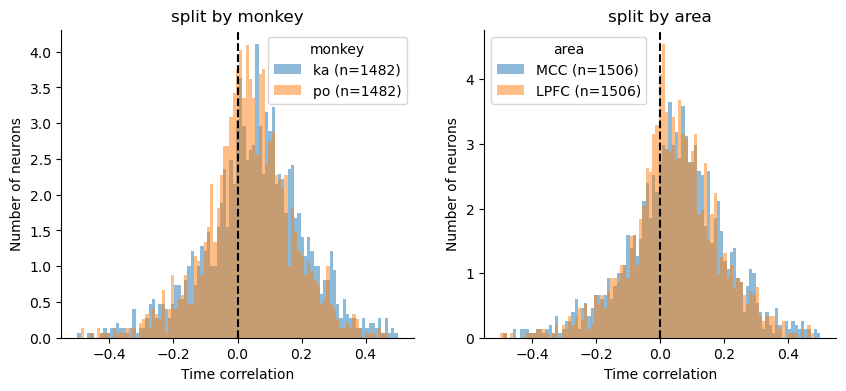

In [7]:
# histogram of time correlation
# split by monkey and by area
fig, axes = plt.subplots(1, 2, figsize=(10,4))
colors = ['tab:blue', 'tab:orange']

for i, condition in enumerate(['monkey', 'area']):
    ax = axes[i]

    unique_labels = neuron_results[condition].unique()
    bins = np.linspace(-.5, .5, 100)

    # measure number of instances per label
    n_elements = [len(neuron_results[neuron_results[condition] == label]) for label in unique_labels]
    minority_class_num = np.min(n_elements)

    for l, label in enumerate(unique_labels):
        data = neuron_results[neuron_results[condition] == label].time_corr
        # random undersampling
        data = np.random.choice(data, size=minority_class_num, replace=False)

        # histogram
        ax.hist(data, bins=bins, density=True, alpha=0.5, label=f'{label} (n={len(data)})', color=colors[l])

    ax.axvline(x=0, color='k', linestyle='--')
    ax.legend(title=condition)
    ax.set_xlabel('Time correlation')
    ax.set_ylabel('Number of neurons')
    ax.set_title('split by {}'.format(condition))

    # remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()


# asd

session_of_day = 1: n_elements = 558
session_of_day = 2: n_elements = 1279
session_of_day = 3: n_elements = 488
session_of_day = 4: n_elements = 230
session_of_day = 5: n_elements = 293
session_of_day = 6: n_elements = 108
session_of_day = 7: n_elements = 23
session_of_day = 8: n_elements = 22
session_of_day = 9: n_elements = 30
channel = 1: n_elements = 48
channel = 2: n_elements = 87
channel = 3: n_elements = 105
channel = 4: n_elements = 146
channel = 5: n_elements = 187
channel = 6: n_elements = 216
channel = 7: n_elements = 230
channel = 8: n_elements = 290
channel = 9: n_elements = 300
channel = 10: n_elements = 305
channel = 11: n_elements = 268
channel = 12: n_elements = 248
channel = 13: n_elements = 193
channel = 14: n_elements = 158
channel = 15: n_elements = 116
channel = 16: n_elements = 134


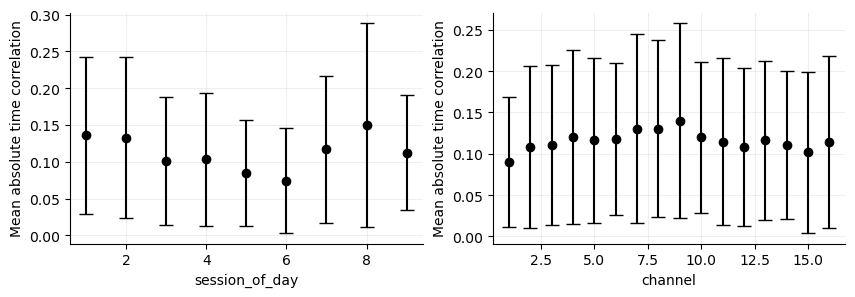

In [8]:
# is the session of day or the recording channel important?
fig, axes = plt.subplots(1, 2, figsize=(10,3))
colors = ['tab:blue', 'tab:orange']

for i, condition in enumerate(['session_of_day', 'channel']):
    ax = axes[i]

    unique_labels = neuron_results[condition].unique()
    # sort
    unique_labels = np.sort(unique_labels)
    bins = np.linspace(-1, 1, 100)

    for label in unique_labels:
        data = neuron_results[neuron_results[condition] == label].time_corr
        data = np.abs(data)
        # plot mean and std, print neumber of samples
        ax.errorbar(x=label, y=data.mean(), yerr=data.std(), color='black', fmt='o', capsize=5)
        print('{} = {}: n_elements = {}'.format(condition, label, len(data)))

        ax.grid(alpha=.2)
        ax.set_xlabel(condition)
        ax.set_ylabel('Mean absolute time correlation')
        # remove spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.show()